In [1]:
## Data analysisi libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Parameter tuning libraries
from sklearn.model_selection import GridSearchCV

## Pre-processing libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## Validation libraries
from sklearn.model_selection import train_test_split, KFold

## Model libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

## Evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report, recall_score

In [2]:
## References

# https://cxl.com/guides/bounce-rate/bounce-rate-vs-exit-rate/
# https://support.google.com/analytics/answer/2525491?hl=en
# https://support.google.com/analytics/answer/2525491?hl=en
# https://support.google.com/analytics/answer/2695658?hl=en#:~:text=Page%20Value%20is%20the%20average,more%20to%20your%20site's%20revenue.

In [3]:
df = pd.read_csv('online_shoppers_intention.csv')
#source : https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset#

In [4]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [10]:
df['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [5]:
df.shape

(12330, 18)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [7]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

### EDA

Inspect how the months affect the spending intent of a user by looking at how the proportion of true and false changes over the months.

In [8]:
df['Month'].value_counts()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64

In [9]:
pd.crosstab(df['Month'], df['Revenue'], normalize = 'index')

Revenue,False,True
Month,,
Aug,0.824480,0.175520
Dec,0.874928,0.125072
Feb,0.983696,0.016304
Jul,0.847222,0.152778
June,0.899306,0.100694
Mar,0.899318,0.100682
May,0.891498,0.108502
Nov,0.746498,0.253502
Oct,0.790528,0.209472


Seeing that the proportions are uneven for the months we look into how special days affect the the tendency of a user to make a purchase.

In [10]:
df['SpecialDay'].value_counts()

0.0    11079
0.6      351
0.8      325
0.4      243
0.2      178
1.0      154
Name: SpecialDay, dtype: int64

In [11]:
pd.crosstab(df['SpecialDay'], df['Revenue'], normalize = 'index')

Revenue,False,True
SpecialDay,,
0.0,0.834732,0.165268
0.2,0.921348,0.078652
0.4,0.946502,0.053498
0.6,0.917379,0.082621
0.8,0.966154,0.033846
1.0,0.935065,0.064935


In [12]:
SpecialDayXMonth = pd.pivot_table(df, values = 'SpecialDay', index = 'Month', aggfunc = np.mean)
SpecialDayXMonth

,SpecialDay
Month,
Aug,0.000000
Dec,0.000000
Feb,0.233696
Jul,0.000000
June,0.000000
Mar,0.000000
May,0.212366
Nov,0.000000
Oct,0.000000


We will also look if sessions during weekends are more likely to end with a purchase

In [13]:
pd.crosstab(df['Weekend'], df['Revenue'], normalize = 'index')

Revenue,False,True
Weekend,,
False,0.851089,0.148911
True,0.826011,0.173989


Whether the type of visitor affects the proportions of buying.

In [14]:
df['VisitorType'].value_counts()

Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64

In [15]:
pd.crosstab(df['VisitorType'], df['Revenue'], normalize = 'index')

Revenue,False,True
VisitorType,,
New_Visitor,0.750885,0.249115
Other,0.811765,0.188235
Returning_Visitor,0.860677,0.139323


### Experiments using combination of numeric and categorical features

Experimenting with using both categorical and numeric features. Numeric features will be preprocessed using a standard scaler and categorical features will be encoded using one hot encoding. 

Functions were made to speed up experimentation.
1. **NumCatPipe**
    - Description
        - Creates the needed X and y matrices depending on the given features to include. This function also prepares the pipelines composed of a pre-processor and a classifier.
    - Parameters
        - numeric_feaures : list of numeric features to include in the model and data
        - categorical_features : list of categorical features to include in the model and data
        - data : dataframe to use
    - Return
        - X and y matrix that includes the appropriate features
        - Two different pipelines of pre-processing step + a specific model
        
2. **CrossValidationPipe**
    - Description
        - Pre-processes the X and y matrices using one-hot encoding and standard scaler so that this process will not be repeated during cross-validation. Prepares the classfiers as well.
    - Parameters
        - numeric_feaures : list of numeric features to include in the model and data
        - categorical_features : list of categorical features to include in the model and data
        - data : dataframe to use
    - Return
        - X_t and y - pre-processed feature values and the target vector
        - mlp and knn classifiers with some parameters fixed.
        
3. **fit_report**
    - Description
        - Fits the model to the given data and prints out the classification report and confusion matrix.
    - Parameters
        - clf : pipeline including pre-processing and a classifier
        - X : the feature set
        - y : the target vector
    - Return
        - no return
        
4. **GridSearch_report**
    - Description
        - Perform gridsearch given a set of parameters to test and a model to use and reports the best performance (recall) and the parameters that were used.
    - Parameters
        - param_grid : set of parameters to use in grid search
        - clf : model to use
        - X : pre-processed feature values
        - y : target vector
    - Return
        - Prints the best performance (recall) and the paramters used. 

In [16]:
def NumCatPipe(numeric_features, categorical_features, data):
    
    # get list of features to drop
    features_set = set(data.columns)
    features_to_drop = list(features_set - set(numeric_features) - set(categorical_features))
    
    # prepare X and y
    X = data.drop(labels = features_to_drop, axis = 1)
    y = data['Revenue'].replace({False : -1, True : 1})
    
    # prepare pipelines
    numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    knn = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', KNeighborsClassifier())])

    mlp = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', MLPClassifier(activation = 'relu',
                                                       hidden_layer_sizes = (5000,),
                                                       max_iter = 1000, shuffle = True))])
    
    return X, y, knn, mlp

In [75]:
def CrossValidationPipe(numeric_features, categorical_features, data):
    
    # get list of features to drop
    features_set = set(data.columns)
    features_to_drop = list(features_set - set(numeric_features) - set(categorical_features))
    
    # prepare X and y
    X = data.drop(labels = features_to_drop, axis = 1)
    y = data['Revenue'].replace({False : -1, True : 1})
    
    # prepare pipelines
    numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    X_t = preprocessor.fit_transform(X,y)
    
    knn = KNeighborsClassifier()
    
    mlp = MLPClassifier(max_iter = 1000, shuffle = True, activation = 'tanh')
    
    return X_t, y, knn, mlp

In [18]:
def fit_report(clf, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test,y_pred))

In [19]:
## Grid Search
def GridSearch_report(param_grid, clf, X, y):

    grid_search = GridSearchCV(clf, param_grid, scoring = 'recall',cv=10)
    grid_search.fit(X,y)
    
    print("Best average recall: %.2f" % grid_search.best_score_)
    print("Parameters : %s" % grid_search.best_params_)

In [20]:
knn_parameters = {'n_neighbors' : list(range(10,30)),
                  'weights' : ('uniform', 'distance'),
                  'p' : [1,2]
                 }

In [21]:
mlp_parameters = {'activation' : ('relu', 'tanh'),
                  'hidden_layer_sizes' : [(75,),(75, 50, 25, 12, 5), (500,)]
                 }

In [22]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=['Administrative', 'Administrative_Duration', 'Informational',
                                                   'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                                                   'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'],
                               categorical_features=['Month','OperatingSystems', 'Browser', 
                                                     'Region', 'TrafficType', 'VisitorType',
                                                     'Weekend'],
                               data = df)

### Using all features

In [23]:
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month','OperatingSystems', 'Browser', 
                        'Region', 'TrafficType', 'VisitorType',
                        'Weekend']

In [24]:
# Data and model preparation
X, y, knn, mlp = NumCatPipe(numeric_features=numeric_features,
                               categorical_features=categorical_features,
                               data = df)

In [25]:
# KNN
fit_report(knn, X, y)

[[1990   65]
 [ 259  152]]
              precision    recall  f1-score   support

          -1       0.88      0.97      0.92      2055
           1       0.70      0.37      0.48       411

    accuracy                           0.87      2466
   macro avg       0.79      0.67      0.70      2466
weighted avg       0.85      0.87      0.85      2466



In [26]:
# MLP
fit_report(mlp, X, y)

[[1918  137]
 [ 170  241]]
              precision    recall  f1-score   support

          -1       0.92      0.93      0.93      2055
           1       0.64      0.59      0.61       411

    accuracy                           0.88      2466
   macro avg       0.78      0.76      0.77      2466
weighted avg       0.87      0.88      0.87      2466



In [27]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [28]:
# KNN optimization
GridSearch_report(knn_parameters, knn, X_t, y)

Best average recall: 0.35
Parameters : {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [29]:
# MLP optimization
GridSearch_report(mlp_parameters, mlp, X_t, y)

Best average recall: 0.50
Parameters : {'activation': 'tanh', 'hidden_layer_sizes': (500,)}


### Using all numeric features only

In [30]:
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
                    'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = []

In [31]:
# Data and model preparation
X, y, knn, mlp = NumCatPipe(numeric_features=numeric_features,
                                 categorical_features=categorical_features,
                                 data = df)

In [32]:
# KNN
fit_report(knn, X, y)

[[1972   83]
 [ 210  201]]
              precision    recall  f1-score   support

          -1       0.90      0.96      0.93      2055
           1       0.71      0.49      0.58       411

    accuracy                           0.88      2466
   macro avg       0.81      0.72      0.75      2466
weighted avg       0.87      0.88      0.87      2466



In [33]:
# MLP
fit_report(mlp, X, y)

[[1946  109]
 [ 172  239]]
              precision    recall  f1-score   support

          -1       0.92      0.95      0.93      2055
           1       0.69      0.58      0.63       411

    accuracy                           0.89      2466
   macro avg       0.80      0.76      0.78      2466
weighted avg       0.88      0.89      0.88      2466



In [34]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [35]:
# KNN optimization
GridSearch_report(knn_parameters, knn, X_t, y)

Best average recall: 0.48
Parameters : {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [36]:
# MLP optimization
GridSearch_report(mlp_parameters, mlp, X_t, y)

Best average recall: 0.57
Parameters : {'activation': 'relu', 'hidden_layer_sizes': (500,)}


### Using all categorical features

In [37]:
numeric_features = []
categorical_features = ['Month','OperatingSystems', 'Browser', 
                        'Region', 'TrafficType', 'VisitorType',
                        'Weekend']

In [39]:
# Data and model preparation
X, y, knn, mlp = NumCatPipe(numeric_features=numeric_features,
                                 categorical_features=categorical_features,
                                 data = df)

In [40]:
# KNN
fit_report(knn, X, y)

[[1957   98]
 [ 358   53]]
              precision    recall  f1-score   support

          -1       0.85      0.95      0.90      2055
           1       0.35      0.13      0.19       411

    accuracy                           0.82      2466
   macro avg       0.60      0.54      0.54      2466
weighted avg       0.76      0.82      0.78      2466



In [41]:
# MLP
fit_report(mlp, X, y)

[[1960   95]
 [ 365   46]]
              precision    recall  f1-score   support

          -1       0.84      0.95      0.89      2055
           1       0.33      0.11      0.17       411

    accuracy                           0.81      2466
   macro avg       0.58      0.53      0.53      2466
weighted avg       0.76      0.81      0.77      2466



In [42]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [43]:
# KNN optimization
GridSearch_report(knn_parameters, knn, X_t, y)

Best average recall: 0.07
Parameters : {'n_neighbors': 13, 'p': 1, 'weights': 'distance'}


In [44]:
# MLP optimization
GridSearch_report(mlp_parameters, mlp, X_t, y)

Best average recall: 0.10
Parameters : {'activation': 'relu', 'hidden_layer_sizes': (500,)}


### Using google analytics metrics only

In [45]:
numeric_features = ['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = []

In [46]:
# Data and model preparation
X, y, knn, mlp = NumCatPipe(numeric_features=numeric_features,
                                 categorical_features=categorical_features,
                                 data = df)

In [47]:
# KNN
fit_report(knn, X, y)

[[1942  113]
 [ 186  225]]
              precision    recall  f1-score   support

          -1       0.91      0.95      0.93      2055
           1       0.67      0.55      0.60       411

    accuracy                           0.88      2466
   macro avg       0.79      0.75      0.76      2466
weighted avg       0.87      0.88      0.87      2466



In [48]:
# MLP
fit_report(mlp, X, y)

[[1955  100]
 [ 190  221]]
              precision    recall  f1-score   support

          -1       0.91      0.95      0.93      2055
           1       0.69      0.54      0.60       411

    accuracy                           0.88      2466
   macro avg       0.80      0.74      0.77      2466
weighted avg       0.87      0.88      0.88      2466



In [49]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [50]:
# KNN optimization
GridSearch_report(knn_parameters, knn, X_t, y)

Best average recall: 0.55
Parameters : {'n_neighbors': 13, 'p': 1, 'weights': 'uniform'}


In [51]:
# MLP optimization
GridSearch_report(mlp_parameters, mlp, X_t, y)

Best average recall: 0.60
Parameters : {'activation': 'tanh', 'hidden_layer_sizes': (500,)}


### Using google analytics and page duration information

In [60]:
numeric_features = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration',
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = []

In [61]:
# Data and model preparation
X, y, knn, mlp = NumCatPipe(numeric_features=numeric_features,
                            categorical_features=categorical_features,
                            data = df)

In [54]:
# KNN
fit_report(knn, X, y)

[[1945  110]
 [ 199  212]]
              precision    recall  f1-score   support

          -1       0.91      0.95      0.93      2055
           1       0.66      0.52      0.58       411

    accuracy                           0.87      2466
   macro avg       0.78      0.73      0.75      2466
weighted avg       0.87      0.87      0.87      2466



In [55]:
# MLP
fit_report(mlp, X, y)

[[1969   86]
 [ 186  225]]
              precision    recall  f1-score   support

          -1       0.91      0.96      0.94      2055
           1       0.72      0.55      0.62       411

    accuracy                           0.89      2466
   macro avg       0.82      0.75      0.78      2466
weighted avg       0.88      0.89      0.88      2466



In [56]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [57]:
# KNN optimization
GridSearch_report(knn_parameters, knn, X_t, y)

Best average recall: 0.53
Parameters : {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [59]:
# MLP optimization
GridSearch_report(mlp_parameters, mlp, X_t, y)

Best average recall: 0.57
Parameters : {'activation': 'tanh', 'hidden_layer_sizes': (500,)}


### Using google analytics and categorical information

In [62]:
numeric_features = ['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month','OperatingSystems', 'Browser', 
                        'Region', 'TrafficType', 'VisitorType',
                        'Weekend']

In [63]:
# Data and model preparation
X, y, knn, mlp = NumCatPipe(numeric_features=numeric_features,
                            categorical_features=categorical_features,
                            data = df)

In [64]:
# KNN
fit_report(knn, X, y)

[[1983   72]
 [ 253  158]]
              precision    recall  f1-score   support

          -1       0.89      0.96      0.92      2055
           1       0.69      0.38      0.49       411

    accuracy                           0.87      2466
   macro avg       0.79      0.67      0.71      2466
weighted avg       0.85      0.87      0.85      2466



In [65]:
# MLP
fit_report(mlp, X, y)

[[1913  142]
 [ 182  229]]
              precision    recall  f1-score   support

          -1       0.91      0.93      0.92      2055
           1       0.62      0.56      0.59       411

    accuracy                           0.87      2466
   macro avg       0.77      0.74      0.75      2466
weighted avg       0.86      0.87      0.87      2466



In [67]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [68]:
# KNN optimization
GridSearch_report(knn_parameters, knn, X_t, y)

Best average recall: 0.38
Parameters : {'n_neighbors': 10, 'p': 2, 'weights': 'distance'}


In [69]:
# MLP optimization
GridSearch_report(mlp_parameters, mlp, X_t, y)

Best average recall: 0.49
Parameters : {'activation': 'relu', 'hidden_layer_sizes': (75,)}


### Improving the best model

In [76]:
mlp_parameters2 = {'hidden_layer_sizes' : [(500,), (1000,), (2000,)]}

In [77]:
numeric_features = ['BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = []

In [78]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [79]:
# MLP optimization
GridSearch_report(mlp_parameters2, mlp, X_t, y)

Best average recall: 0.60
Parameters : {'hidden_layer_sizes': (1000,)}


#### Add number of webpages visited as feature

In [80]:
numeric_features = ['Administrative', 'Informational', 'ProductRelated', 
                    'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = []

In [81]:
X_t, y, knn, mlp = CrossValidationPipe(numeric_features=numeric_features,
                                       categorical_features=categorical_features,
                                       data = df)

In [82]:
# MLP optimization
GridSearch_report(mlp_parameters2, mlp, X_t, y)

Best average recall: 0.57
Parameters : {'hidden_layer_sizes': (2000,)}


## Visualization of results

In [18]:
resDict = {
    '[Model] Features': ['[KNN] C+N','[MLP] C+N','[KNN] N','[MLP] N','[KNN] C', '[MLP] C',
                      '[KNN] GA','[MLP] GA','[KNN] GA+P','[MLP] GA+P','[KNN] GA+C', '[MLP] GA+C'],
    'Average Recall' : [0.35,0.50,0.48,0.57,0.07,0.10,0.55,0.60,0.53,0.57,0.38,0.49]
}

In [19]:
res = pd.DataFrame(resDict)

In [20]:
res.head()

,[Model] Features,Average Recall
0,[KNN] C+N,0.35
1,[MLP] C+N,0.50
2,[KNN] N,0.48
3,[MLP] N,0.57
4,[KNN] C,0.07


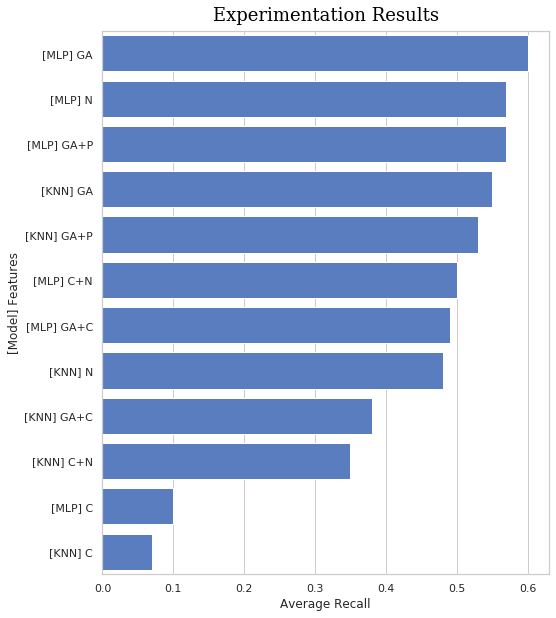

In [32]:
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(8, 10))

font_title = {'family': 'serif',
        'color':  'Black',
        'weight': 'normal',
        'size': 18,
        }

ax.set_title("Experimentation Results", fontdict = font_title, pad =10)

sns.set_color_codes("muted")
sns.barplot(x="Average Recall", y="[Model] Features", 
            data=res.sort_values(by = 'Average Recall', ascending = False),
            color="b")



plt.show()

# Code dump

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
X = df.drop(labels = ['Revenue'], axis = 1)
y = df['Revenue'].replace({False : -1, True : 1})

In [ ]:
df.columns

In [ ]:
# Tranformer pipeline
numeric_features = ['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay']
categorical_features = ['Month','OperatingSystems', 'Browser', 
                        'Region', 'TrafficType', 'VisitorType',
                       'Weekend']

numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps = [('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

preprocessorpipe= Pipeline(steps=[('preprocessor', preprocessor)])
    
knn = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', KNeighborsClassifier())])

mlp = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MLPClassifier(activation = 'tanh',
                                                   hidden_layer_sizes = (100,),
                                                   max_iter = 1000, shuffle = True))])

svc = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SVC())])

In [ ]:
X_t = preprocessorpipe.fit_transform(X,y)

In [ ]:
knn = KNeighborsClassifier()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.2, random_state=42)

In [ ]:
#knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
## Grid Search
knn_param_grid = {
    'classifier__n_neighbors' : list(range(10,12)),
    'classifier__weights' : ('distance', 'uniform')
}

grid_search = GridSearchCV(knn, knn_param_grid, scoring = 'recall',cv=10)
grid_search.fit(X,y)
resKNN = pd.DataFrame(grid_search.cv_results_)
resKNN.sort_values(by = 'rank_test_score').head(10)

In [ ]:
clf = grid_search.best_estimator_

In [ ]:
print("Best recall: " + str(grid_search.best_score_))

In [ ]:
print("Best average recall: %.2f" % grid_search.best_score_)
print("Parameters : %s" % grid_search.best_params_)

In [ ]:
clf.fit(X,y)

In [ ]:
## Grid Search
mlp_param_grid = {
    'classifier__n_neighbors' : list(range(10,40)),
    'classifier__weights' : ('uniform', 'distance'),
    'classifier__p' : [2]
}

grid_search = GridSearchCV(knn, knn_param_grid, scoring = 'recall',cv=10)
grid_search.fit(X,y)

In [ ]:
df.columns

In [ ]:
X = df.drop(labels = ['Revenue', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend'], axis = 1)
y = df['Revenue'].replace({False : -1, True : 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standar Scaler Pipes
KNNPipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])
MLPPipe = Pipeline([('scaler', StandardScaler()), ('mlp', MLPClassifier(activation = 'tanh',
                                                   hidden_layer_sizes = (100,),
                                                   max_iter = 1000, shuffle = True))])

In [ ]:
KNNPipe.fit(X_train, y_train)
y_pred = KNNPipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
MLPPipe.fit(X_train, y_train)
MLPpred = MLPPipe.predict(X_test)
print(confusion_matrix(y_test, MLPpred))
print(classification_report(y_test,MLPpred))

In [ ]:
df.columns

In [ ]:
X = df.drop(labels = ['Revenue', 'Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay'], axis = 1)
y = df['Revenue'].replace({False : -1, True : 1})

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standar Scaler Pipes
KNNPipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')), ('knn', KNeighborsClassifier())])
MLPPipe = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore')), ('mlp', MLPClassifier(activation = 'tanh',
                                                   hidden_layer_sizes = (100,),
                                                   max_iter = 1000, shuffle = True))])

In [ ]:
KNNPipe.fit(X_train, y_train)
y_pred = KNNPipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

In [ ]:
MLPPipe.fit(X_train, y_train)
MLPpred = MLPPipe.predict(X_test)
print(confusion_matrix(y_test, MLPpred))
print(classification_report(y_test,MLPpred))